In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from qnorm import quantile_normalize
from wmb import cemba
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

from ALLCools.mcds.correlation import corr_rows

In [2]:
group_name = "chr19_0"

In [3]:
chrom, group = group_name.split("_")
dmr_bed = pd.read_csv('dmr.csv.gz', index_col=0)
use_dmr_ids = dmr_bed.index
use_dmr_ids.size

55052

In [4]:
dmr_ds = xr.open_zarr('/cemba/wmb/genome/DMR/CEMBA.snmC.AllGroupedDMRs.mCGATACQnorm.zarr/')
dmr_ds = dmr_ds.sel(dmr=use_dmr_ids)

In [5]:
dmr_ds

<xarray.Dataset>
Dimensions:       (dmr: 55052, sample_id: 4673)
Coordinates:
    corr          (dmr) float32 dask.array<chunksize=(55052,), meta=np.ndarray>
    corr_shuffle  (dmr) float32 dask.array<chunksize=(55052,), meta=np.ndarray>
  * dmr           (dmr) <U30 'chr19-3079647:0-2' ... 'chr19-61329595:141-162'
  * sample_id     (sample_id) <U18 'c1_c3_c0_c1_r4' ... 'c16_c2_c0_c0_r0'
Data variables:
    atac          (dmr, sample_id) float32 dask.array<chunksize=(7913, 200), meta=np.ndarray>
    mc            (dmr, sample_id) float32 dask.array<chunksize=(7913, 200), meta=np.ndarray>

In [6]:
# mC Frac, already normalized
mc_data = dmr_ds["mc"].to_pandas()

# ATAC data, already normalized
atac_data = dmr_ds["atac"].to_pandas()

In [11]:
# cluster_to_ct = cemba.get_mc_annot()['L4Region_cat_annot'].to_pandas()
# cluster_to_ct.to_csv('cluster_to_ct.csv')
cluster_to_ct = pd.read_csv('/mnt/filestore/221203-dmr-mc-atac-corr/cell_type_corr/cluster_to_ct.csv', index_col=0).squeeze()
cluster_to_ct.index.name = 'Cluster'
cluster_to_ct.name = 'CellType'

In [15]:
# group cluster to ct
mc_data = mc_data.groupby(cluster_to_ct, axis=1).mean()
atac_data = atac_data.groupby(cluster_to_ct, axis=1).mean()

Text(0.5, 1.0, 'ATAC 0.01 0.29')

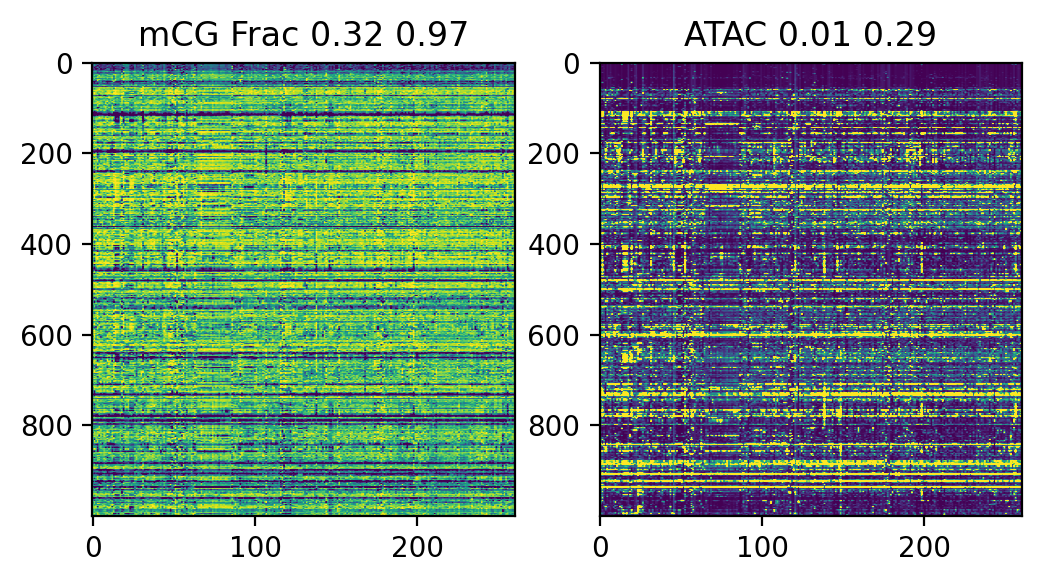

In [16]:
fig, axes = plt.subplots(figsize=(6, 3), ncols=2, dpi=200)
ax = axes[0]
vmin, vmax = np.quantile(mc_data.iloc[:1000], [0.1, 0.9])
ax.imshow(mc_data.iloc[:1000], aspect="auto", vmin=vmin, vmax=vmax)
ax.set_title(f"mCG Frac {vmin:.2f} {vmax:.2f}")
ax = axes[1]
vmin, vmax = np.quantile(atac_data.iloc[:1000], [0.1, 0.9])
ax.imshow(atac_data.iloc[:1000], aspect="auto", vmin=vmin, vmax=vmax)
ax.set_title(f"ATAC {vmin:.2f} {vmax:.2f}")

In [17]:
corr = corr_rows(mc_data, atac_data)

In [18]:
shuffle_mc_data = pd.DataFrame(
    [col.sample(mc_data.shape[0]).values for _, col in mc_data.items()]
).T

In [19]:
shuffle_atac_data = pd.DataFrame(
    [col.sample(atac_data.shape[0]).values for _, col in atac_data.items()]
).T

In [20]:
shuffle_corr = corr_rows(shuffle_mc_data, shuffle_atac_data)

<AxesSubplot:ylabel='Count'>

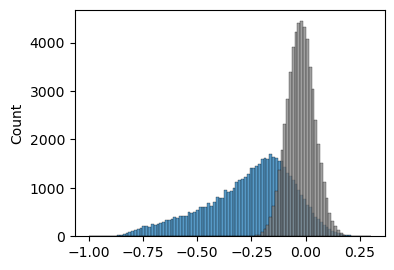

In [21]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=100)
sns.histplot(ax=ax, data=corr, bins=100, binrange=(-1, 0.3))
sns.histplot(ax=ax, data=shuffle_corr, color='grey', bins=100, binrange=(-1, 0.3))

In [22]:
corr_data = pd.DataFrame({'corr': corr, 'shuffle': shuffle_corr}, index=mc_data.index)

In [23]:
corr_data.to_pickle('corr.pickle')